In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def proba_twice_below(x_0, σ, r, patient,g):
    # Define the mean vector
    mean = np.array([x_0 + g*(1-patient), x_0 + (1+r)*patient*g])
    # Var(x_1) = \sigma^2
    # Var(x_2) = 2 * \sigma^2 (because it's the sum of two independent normal variables)
    # Cov(x_1, x_2) = \sigma^2 (because they share one common perturbation)
    cov = np.array([[σ**2, σ**2],
                    [σ**2, 2*σ**2]])
    # Compute the probability using the multivariate normal CDF
    prob = stats.multivariate_normal.cdf([0, 0], mean=mean, cov=cov)
    return prob

def proba_once_below(x_0,σ,r, patient,g):
    #p(A U B) = p(A) + p(B) - p(A inter B)
    return stats.norm.cdf(-(x_0 + g*(1-patient)) / σ) + stats.norm.cdf(-(x_0 + (1+r)*patient*g)/ (σ * np.sqrt(2))) - proba_twice_below(x_0, σ,r, patient,g)

##Cliff scenario    
def proba_below_1(x_0,σ,r, patient,g):
    return stats.norm.cdf(-(x_0 + g*(1-patient)) / σ)
def proba_below_2(x_0,σ,r, patient,g):
    return stats.norm.cdf(-(x_0 + g*(1-patient) + (1+r)*patient*g)/ (σ * np.sqrt(2)))



def expected_utility_cliff(x_0,σ, r=0, patient=False,g=0,α=1):
    u = x_0 + g - α*(proba_below_1(
        x_0, σ, r, patient,g)  + proba_below_2(
        x_0,σ, r, patient,g))
    return u

In [6]:
## One strike and you're out scenario
def expected_utility_onestrike(x_0, σ, r=0, g=0, patient=False,drift=0, base = 5):
    # Define the mean vector and covariance matrix for x_1 and x_2
    mean = np.array([x_0 + g*(1-patient), x_0 + g*(1-patient) + (1+r)*patient*g + drift])
    cov = np.array([[σ**2, σ**2],
                    [σ**2, 2*σ**2]])
    
    # Compute probability that both x_1 > 0 and x_2 > 0
    #cdf_5_5 = stats.multivariate_normal.cdf([5, 5], mean=mean, cov=cov)
    # Compute the marginal CDFs
    #cdf_x1_5 = stats.norm.cdf(5, loc=mean[0], scale=np.sqrt(cov[0, 0]))
    #cdf_x2_5 = stats.norm.cdf(5, loc=mean[1], scale=np.sqrt(cov[1, 1]))
    # Compute the probability that X1 > 5 and X2 > 5
    #prob_both_above = 1 - (cdf_x1_5 + cdf_x2_5 - cdf_5_5)
    # Compute expected value of x_2 given that both x_1 > 0 and x_2 > 0
    # We need to use the conditional expectation formula for bivariate normal distribution
    def integrand(x1, x2):
        return (x2+base) * stats.multivariate_normal.pdf([x1, x2], mean=mean, cov=cov)
    
    # Numerical integration to compute E[x_2 | x_1 > 0, x_2 > 0]
    from scipy import integrate
    expected_x2_given_both_above, _ = integrate.dblquad(
        integrand, 0, np.inf, lambda x: 0, lambda x: np.inf
    )
    #expected_x2_given_both_above /= prob_both_above
    
    # Compute expected utility
    #expected_utility = prob_both_above * expected_x2_given_both_above
    expected_utility = expected_x2_given_both_above
    return expected_utility


In [30]:
## One-off threshold scenario
def expected_utility_oneoff(x_0, σ, r=0, g=0, patient=False,drift=0, base = 5):
    #Formula: x_2*(x_1> 0 + x_2 > 0)
    
    mean = np.array([x_0 + g*(1-patient), x_0 + g*(1-patient) + (1+r)*patient*g + drift])
    cov = np.array([[σ**2, σ**2],
                    [σ**2, 2*σ**2]])
    # Compute expected value of x_2 given that both x_1 > 0 and x_2 > 0
    # We need to use the conditional expectation formula for bivariate normal distribution
    def integrand(x1, x2):
        return (x2+base) * stats.multivariate_normal.pdf([x1, x2], mean=mean, cov=cov)
    # Numerical integration to compute E[x_2 | x_1 > 0, x_2 > 0]
    from scipy import integrate
    #payoff_1, _ = integrate.dblquad(
    #    integrand, 0, np.inf, lambda x: -np.inf, lambda x: np.inf, epsabs=1e-12, epsrel=1e-12
    #)
    #payoff_2, _ = integrate.dblquad(
    #    integrand, -np.inf, np.inf, lambda x: 0, lambda x: np.inf, epsabs=1e-12, epsrel=1e-12
    #)
    def integrand_t1(x_1):
        return x_1*stats.norm.pdf(x_1,loc=x_0 + g*(1-patient),scale=σ)
    def integrand_t2(x_2):
        return x_2*stats.norm.pdf(x_2,loc=x_0 + g*(1-patient) + (1+r)*patient*g,scale=np.sqrt(2)*σ)
    a = integrate.quad(integrand_t1,0,np.inf)
    b = integrate.quad(integrand_t2,0,np.inf)
    return a[0] + b[0]

def get_interest_rate(x_0,σ,g,R = np.linspace(0,.1,30)):
    utility_impatient = expected_utility(x_0,σ, 0, g,False)[0]
    z = np.abs(np.array([expected_utility(x_0,σ, r, g,True)[0] - utility_impatient for r in R]))
    i = np.argmin(z)
    return R[i]
    
def discount_factor(x_0,σ,expected_utility):
    baseline = expected_utility(x_0,σ,r=0,g=0,patient=False)
    marginal_t1 = expected_utility(x_0,σ,r=0,g=.001,patient=False) - baseline
    marginal_t2 = expected_utility(x_0,σ,r=0,g=.001,patient=True) - baseline
    return(marginal_t1/marginal_t2)






  0%|                                                    | 0/50 [00:00<?, ?it/s]




 48%|████████████████████▏                     | 24/50 [00:00<00:00, 231.88it/s]




100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 102.55it/s]


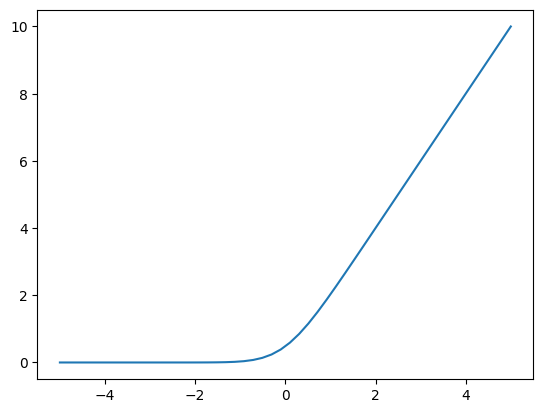

In [31]:
X = np.linspace(-5,5)
plt.plot(X,[expected_utility_oneoff(x_0=x_0,σ = .5) for x_0 in tqdm(X)])

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                    | 0/50 [00:00<?, ?it/s]

  2%|▉                                           | 1/50 [00:08<06:55,  8.48s/it]

  4%|█▊                                          | 2/50 [00:17<06:52,  8.59s/it]

  6%|██▋                                         | 3/50 [00:25<06:44,  8.61s/it]

  8%|███▌                                        | 4/50 [00:34<06:42,  8.75s/it]

 10%|████▍                                       | 5/50 [00:43<06:36,  8.82s/it]

 12%|█████▎                                      | 6/50 [00:52<06:32,  8.93s/it]

 14%|██████▏                                     | 7/50 [01:02<06:34,  9.17s/it]

 16%|███████                                     | 8/50 [01:12<06:36,  9.43s/it]

 18%|███████▉                                    | 9/50 [01:22<06:36,  9.67s/it]

 20%|████████▌                                  | 10/50 [01:34<06:50, 10.25s/it]

 22%|█████████▍ 

 82%|███████████████████████████████████▎       | 41/50 [01:19<00:24,  2.76s/it]

 84%|████████████████████████████████████       | 42/50 [01:22<00:22,  2.78s/it]

 86%|████████████████████████████████████▉      | 43/50 [01:25<00:19,  2.81s/it]

 88%|█████████████████████████████████████▊     | 44/50 [01:28<00:17,  2.99s/it]

 90%|██████████████████████████████████████▋    | 45/50 [01:32<00:15,  3.11s/it]

 92%|███████████████████████████████████████▌   | 46/50 [01:35<00:12,  3.23s/it]

 94%|████████████████████████████████████████▍  | 47/50 [01:39<00:09,  3.33s/it]

 96%|█████████████████████████████████████████▎ | 48/50 [01:42<00:06,  3.37s/it]

 98%|██████████████████████████████████████████▏| 49/50 [01:46<00:03,  3.41s/it]

100%|███████████████████████████████████████████| 50/50 [01:49<00:00,  2.20s/it]


100%|███████████████████████████████████████████| 1/1 [16:43<00:00, 1003.30s/it]


Text(0, 0.5, 'Discount rate')

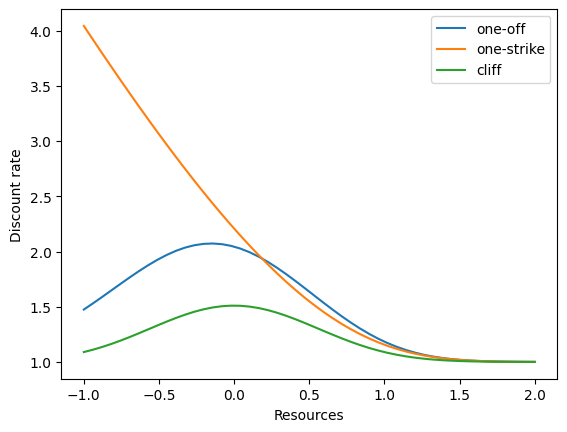

In [18]:
X = np.linspace(-1,2,50)
for s in tqdm([1]):
    plt.plot(X,[discount_factor(x_0,σ=.5,expected_utility=expected_utility_oneoff) for x_0 in tqdm(X)],label="one-off")
    plt.plot(X,[discount_factor(x_0,σ=.5,expected_utility=expected_utility_onestrike) for x_0 in tqdm(X)],label="one-strike")
    plt.plot(X,[discount_factor(x_0,σ=.5,expected_utility=expected_utility_cliff) for x_0 in tqdm(X)],label = "cliff")
plt.legend()
plt.xlabel("Resources")
plt.ylabel("Discount rate")






  0%|                                                     | 0/1 [00:00<?, ?it/s]





100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.61it/s]


Text(0, 0.5, 'Discount rate')

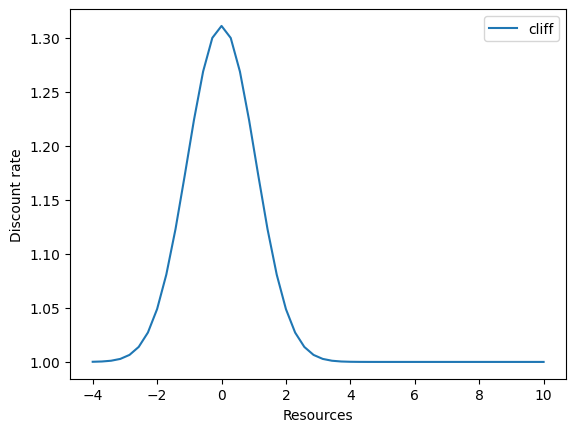

In [35]:
X = np.linspace(-4,10,50)
for s in tqdm([1]):
    #plt.plot(X,[discount_factor(x_0,σ=.5,expected_utility=expected_utility_oneoff) for x_0 in tqdm(X)],label="one-off")
    #plt.plot(X,[discount_factor(x_0,σ=.5,expected_utility=expected_utility_onestrike) for x_0 in tqdm(X)],label="one-strike")
    plt.plot(X,[discount_factor(x_0,σ=1,expected_utility=expected_utility_cliff) for x_0 in tqdm(X)],label = "cliff")
plt.legend()
plt.xlabel("Resources")
plt.ylabel("Discount rate")